## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusions](#conclusions)
- [Part V - Resources](#source)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
# no of rows
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
# no of unique users in the dataset
df['user_id'].nunique()

290584

In [5]:
# To investigate if there are any duplicate rows
df.duplicated().value_counts()


False    294478
dtype: int64

**It seems that there are no duplicate rows, but there are repeated users.**

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.count()

user_id         294478
timestamp       294478
group           294478
landing_page    294478
converted       294478
dtype: int64

**No missing values in any of the rows**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) & ((df['group'] == 'control') == (df['landing_page'] == 'old_page'))]

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

In [12]:
df2.shape[0]

290585

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# To have a look on the repeat user
df2[df2.duplicated(subset='user_id', keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

**Its user_id is 773192, of group 'treatment', and landing_page is 'new_page'.**

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2 = df2.drop_duplicates(subset='user_id')

In [15]:
# to insure the removal of one of the repeated user_id
df2.shape[0]

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
cr = df2['converted'].mean()
cr

0.11959708724499628

### p<sub>population</sub> = cr 

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
cr_control = df2.query('group == "control"').converted.mean()
cr_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
cr_treatment = df2.query('group == "treatment"').converted.mean()
cr_treatment

0.11880806551510564

In [19]:
# The actual difference in the conversion rates between the two groups.
obs_diff = cr_treatment - cr_control
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [20]:
# to calculate probability of every element in a column
df2['landing_page'].value_counts(normalize=True) 

new_page    0.500062
old_page    0.499938
Name: landing_page, dtype: float64

In [21]:
df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**We need to further investigate if the observed difference between conversions in new & old pages is statistically & practically significant.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_0$ : $p_{new}$ - $p_{old}$ ≤  0 <br><br>
$H_1$ :  $p_{new}$ - $p_{old}$ > 0 <br><br> 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [23]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [24]:
# n_new is the no of individuals in the treatment group.
df_new = df2.query('group == "treatment"')
n_new = df_new.shape[0]
n_new

145310

d. What is $n_{old}$?

In [25]:
# n_old is the no of individuals in the control group.
df_old = df2.query('group == "control"')
n_old = df_old.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
#new_page_converted = np.random.choice(2, size=n_new, p=[(1-p_new), p_new])
#new_page_converted,mean()



f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
#old_page_converted = np.random.choice(2, n_old, p=[(1-p_old), p_old])
#old_page_converted.mean()


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
# 𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  for simulated values:
#new_page_converted.mean() - old_page_converted.mean()

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [29]:
# np.random.binomial(n_new,p_new,10000) is 10000
# simulations of the NUMBER of
# successes from n_new trials with prob p_new
# we want the PROPORTION, so we divide by n_new
new_page_converted_mean = np.random.binomial(n_new,p_new,10000)/n_new

old_page_converted_mean = np.random.binomial(n_old,p_old,10000)/n_old

p_diffs = new_page_converted_mean - old_page_converted_mean 
p_diffs

array([ 0.0005211 , -0.00030502, -0.00146111, ..., -0.00067654,
        0.00091327,  0.00024535])

In [30]:
# convert list to array.
#p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

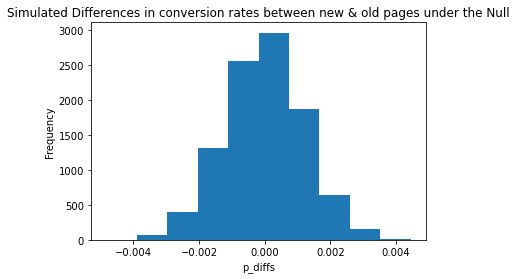

In [31]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Differences in conversion rates between new & old pages under the Null');

 **The mean of p_diffs is 0 meaning that there is no difference in conversion between old & new pages.**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

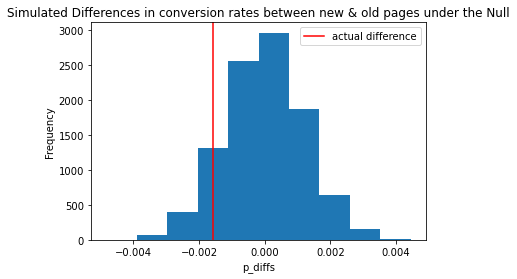

In [32]:
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Differences in conversion rates between new & old pages under the Null')
plt.axvline(obs_diff, color='r', label="actual difference")
plt.legend()
plt.show();

In [33]:
# the proportion of p_diffs greater than observed difference in ab_data.csv
p_value = (p_diffs > obs_diff).mean()
p_value

0.9058

**p_value is greater than the type 1 error rate of 0.05 meaning that there is a high probability that our data is consistent with the null hypothesis.**<br><br>

**Result: fail to reject null hypothesis.** <br><br>

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value is called the "p-value", a p-value that doesn't exceed 0.05, this means that no significant difference in conversion between old & new pages.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

convert_old = df_old.query('converted == 1').shape[0]
convert_new = df_new.query('converted == 1').shape[0]
n_old = df_old.shape[0]  
n_new = df_new.shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [35]:
z_score, p_val = proportions_ztest(np.array([convert_new, convert_old]), np.array([n_new, n_old]), alternative='larger')
z_score,p_val

(-1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p-value is greater than 0.05 (type I error rate) meaning we fail to reject the null hypothesis and there is no significant difference between conversion rates of old & new pages.**<br><br>
**z_score < $Z_{\alpha}$ so it doesn't lie in the rejection region, and we can't reject the null hypothesis.**<br><br>
**this result agrees with the previous findings.**<br><br>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**The type of regression is: logistic regression .**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [37]:
df2['intercept'] = 1
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-07-04 03:51 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value associated with ab_page is 0.1899, which is different from p-value found in part II, this is because the alternative hypothesis of regression models is that difference ≠ 0. i.e. two-sided hypothesis , while in part II the alternative was difference > 0 (one-sided hypothesis), however both are greater than α indicating that there is no significant evidence to reject the null hypothesis.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**I think  It's OK to study the effect of another factors on conversion, but adding more factors that don't affect the response reduces the precision and It would be better to be removed.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
countries_df = pd.read_csv('./countries.csv')
countries_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
# according to the documentation, joining 2 dataframes using 'user_id' as an index.
new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
new.head()

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [41]:
new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [42]:
# to study the impact of country on the rate of conversion.
new.groupby('country').converted.mean()

country
CA    0.115318
UK    0.120594
US    0.119547
Name: converted, dtype: float64

In [43]:
# previously found data
cr_control, cr_treatment, cr

(0.1203863045004612, 0.11880806551510564, 0.11959708724499628)

**It seems that there is no impact of the country on the conversion rate as all countries have similar conversion rates, also conversion rates associated with countries are similar to that associated with a landing page (cr_control, cr_treatment) previously found and similar to the conversion rate of the dataset df2(cr). **

In [44]:
### Create the necessary dummy variables
new[['US', 'UK', 'CA']] = pd.get_dummies(new['country'])
new = new.drop('CA', axis=1)


In [45]:
logit_mod = sm.Logit(new['converted'], new[['intercept','ab_page', 'US', 'UK']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-07-04 03:51 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

**It's obvious that all p_values for page type & countries are greater than type I error rate (0.05), this means that there is no impact of the page type or the country on the rate of conversions and there is a high probability that our data is consistent with the null hypothesis.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
# fitting regression model & summarize the results.
new['US_inter'] = new['US']*new['ab_page']
new['UK_inter'] = new['UK']*new['ab_page']
logit_mod = sm.Logit(new['converted'], new[['intercept','ab_page', 'US', 'UK', 'US_inter', 'UK_inter']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-07-04 03:51 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
US           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
US_inter     -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_inter      0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

**In the last model I investigate the interactions between each country & the page type obviously, the p_values for interactions are greater than 0.05, and there is no effect on conversion.**

<a id='conclusions'></a>
## Part IV - Conclusions
**The goal of the analysis is to compare a newly developed web page with the old one concerning the rate of conversion, so I investigated our dataset in three different approaches, simulating the sampling distribution, using Z-test, and using a logit model. also studied the effect of other factors which may cause bias like the country of the user.** <br><br>
**All methods came to the same result that is we failed to reject the null hypothesis, we haven't enough evidence that the new page is better than the old page, and I recommend that the company develops another page.**

<a id='source'></a>
### Part IV - Resources

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html <br><br>
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html <br><br>
https://www.statology.org/two-proportion-z-test/